# Capstone Project: ResNet-50 for Cats.Vs.Dogs

In [1]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
import random
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Data preprocessing

- The images in train folder are divided into a training set and a validation set.
- The images both in training set and validation set are separately divided into two folders -- cat and dog according to their lables.

*(the two steps above were finished in  Preprocessing train dataset.ipynb)*

- The RGB color values of the images are rescaled to 0~1.
- The size of the images are resized to 224*224.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 224
image_height = 224
image_size = (image_width, image_height)

train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        'mytrain',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
        'myvalid',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='binary')


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


#### show 16 images in the train dataset randomly

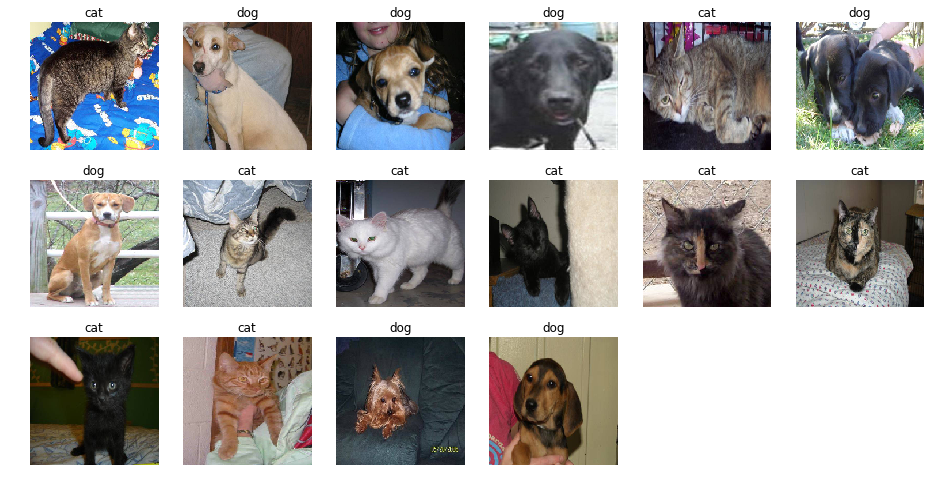

In [3]:
x, y = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

## Build the structure of ResNet-50 for Cats.Vs.Dogs

1. Define identity block.
2. Define convolution block.
3. Build the structure of ResNet-50 without top layer.
4. Load weights
5. Add top layer to ResNet-50.
6. Setup training attribute.
7. Compile the model.

### 1. Define identity block.

#### The identity_block is the block that has no conv layer at shortcut.

#### Arguments

- input_tensor: input tensor
- kernel_size: defualt 3, the kernel size of middle conv layer at main path
- filters: list of integers, the nb_filters of 3 conv layer at main path
- stage: integer, current stage label, used for generating layer names
-  block: 'a','b'..., current block label, used for generating layer names

In [4]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x

### 2. Define convolution block.

#### conv_block is the block that has a conv layer at shortcut

#### Arguments

- input_tensor: input tensor
- kernel_size: defualt 3, the kernel size of middle conv layer at main path
- filters: list of integers, the nb_filters of 3 conv layer at main path
- stage: integer, current stage label, used for generating layer names
- block: 'a','b'..., current block label, used for generating layer names

    *Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well*

In [5]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x

### 3.Build the structure of ResNet-50 without top layer.

In [6]:
img_input = Input(shape=(image_width, image_height, 3))

x = ZeroPadding2D((3, 3))(img_input)
x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, name='bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

base_model = Model(img_input, x)

### 4. Load weights.

In [7]:
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/\
v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        TF_WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        md5_hash='a268eb855778b3df3c7506639542a6af')
base_model.load_weights(weights_path)

### 5. Add top layer to ResNet-50.

In [8]:
x = AveragePooling2D((7, 7), name='avg_pool')(base_model.output)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', name='output')(x)

model = Model(input=base_model.input, output=x)

### 6. Setup training attribute.

*Freeze the weights except the top layer.*

In [9]:
top_num = 4
for layer in model.layers[:-top_num]:
    layer.trainable = False

for layer in model.layers[-top_num:]:
    layer.trainable = True

### 7. Compile the model.

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

## Train ResNet-50 for Cats.Vs.Dogs and Save the best model.

In [11]:
from keras.callbacks import ModelCheckpoint, TensorBoard
best_model = ModelCheckpoint("resnet_best.h5", monitor='val_acc', verbose=0, save_best_only=True)

In [12]:
model.fit_generator(
        train_generator,
        samples_per_epoch=2048,
        nb_epoch=40,
        validation_data=validation_generator,
        nb_val_samples=1024,
        callbacks=[best_model, TensorBoard(log_dir='./logs', histogram_freq=1)])

Epoch 1/40
2048/2048 [==============================] - 31s - loss: 0.5077 - acc: 0.7471 - val_loss: 0.2358 - val_acc: 0.9258
Epoch 2/40
2048/2048 [==============================] - 27s - loss: 0.2803 - acc: 0.8872 - val_loss: 0.1830 - val_acc: 0.9395
Epoch 3/40
2048/2048 [==============================] - 27s - loss: 0.2232 - acc: 0.9165 - val_loss: 0.1193 - val_acc: 0.9660
Epoch 4/40
2048/2048 [==============================] - 26s - loss: 0.1864 - acc: 0.9307 - val_loss: 0.1208 - val_acc: 0.9580
Epoch 5/40
2048/2048 [==============================] - 26s - loss: 0.1759 - acc: 0.9351 - val_loss: 0.1059 - val_acc: 0.9650
Epoch 6/40
2048/2048 [==============================] - 26s - loss: 0.1632 - acc: 0.9409 - val_loss: 0.1095 - val_acc: 0.9590
Epoch 7/40
2048/2048 [==============================] - 27s - loss: 0.1589 - acc: 0.9302 - val_loss: 0.0988 - val_acc: 0.9717
Epoch 8/40
2048/2048 [==============================] - 27s - loss: 0.1578 - acc: 0.9414 - val_loss: 0.0822 - val_acc:

/usr/local/lib/python2.7/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2052/2048 [==============================] - 27s - loss: 0.1309 - acc: 0.9498 - val_loss: 0.0924 - val_acc: 0.9648
Epoch 12/40
2048/2048 [==============================] - 27s - loss: 0.1276 - acc: 0.9526 - val_loss: 0.0734 - val_acc: 0.9814
Epoch 13/40
2048/2048 [==============================] - 26s - loss: 0.1339 - acc: 0.9458 - val_loss: 0.0689 - val_acc: 0.9776
Epoch 14/40
2048/2048 [==============================] - 26s - loss: 0.1188 - acc: 0.9492 - val_loss: 0.0834 - val_acc: 0.9727
Epoch 15/40
2048/2048 [==============================] - 26s - loss: 0.1439 - acc: 0.9409 - val_loss: 0.0778 - val_acc: 0.9708
Epoch 16/40
2048/2048 [==============================] - 26s - loss: 0.1265 - acc: 0.9526 - val_loss: 0.0810 - val_acc: 0.9707
Epoch 17/40
2048/2048 [==============================] - 26s - loss: 0.1177 - acc: 0.9487 - val_loss: 0.0845 - val_acc: 0.9689
Epoch 18/40
2048/2048 [==============================] - 26s - loss: 0.1152 - acc: 0.9565 - val_loss: 0.0908 - val_acc: 0.9

In [13]:
with open('resnet.json', 'w') as f:
    f.write(model.to_json())

## Using the best model to predict images

In [14]:
# with open('resnet.json', 'r') as f:
#     model = model_from_json(f.read())
model.load_weights('resnet_best.h5')

#### preprocessing the images in test dataset

In [15]:
def get_image(index):
    img = cv2.imread('test/%d.jpg' % index)
    img = cv2.resize(img, image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img

test_num = 12500

In [16]:
from tqdm import *

image_matrix = np.zeros((test_num, image_width, image_height, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image(i+1)

100%|██████████| 12500/12500 [00:30<00:00, 412.03it/s]


In [17]:
predictions = model.predict(image_matrix, verbose=1)

12500/12500 [==============================] - 68s    


### Save the result.csv for kaggle submit

In [18]:
s = 'id,label\n'
for i, p in enumerate(predictions):
    s += '%d,%f\n' % (i+1, p)

with open('result.csv', 'w') as f:
    f.write(s)

## Visualization

### Show 20 random images and the prediction in the test folder by the classifier

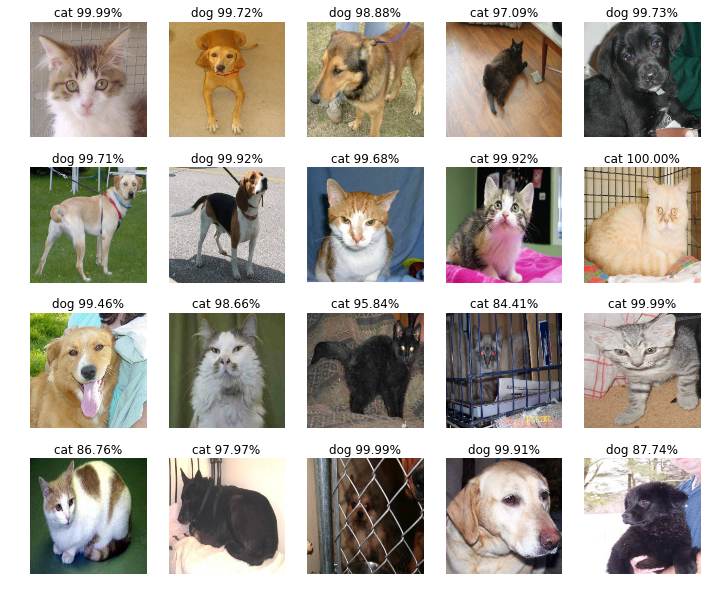

In [19]:
plt.figure(figsize=(12, 10))
for i in range(20):
    x = get_image(random.randint(1, test_num))
    prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


## Draw feature heatmap

The shape of the output of the base model is (7, 7, 2048). 

The shape of the weights of full connection is (2048, 1). 

In order to draw the heatmap, I calculated the Class Activation Mapping (cam) of the output of the network then used OpenCV to visualize the result.

$cam = (P-0.5)*output*w$
- cam: class activation mapping
- P: the probability of cats or dogs
- output: the output of base model
- w: the weights of the full connection

In [20]:
weights = model.layers[-1].get_weights()[0]
model2 = Model(input=model.input, output=[base_model.output, model.output])

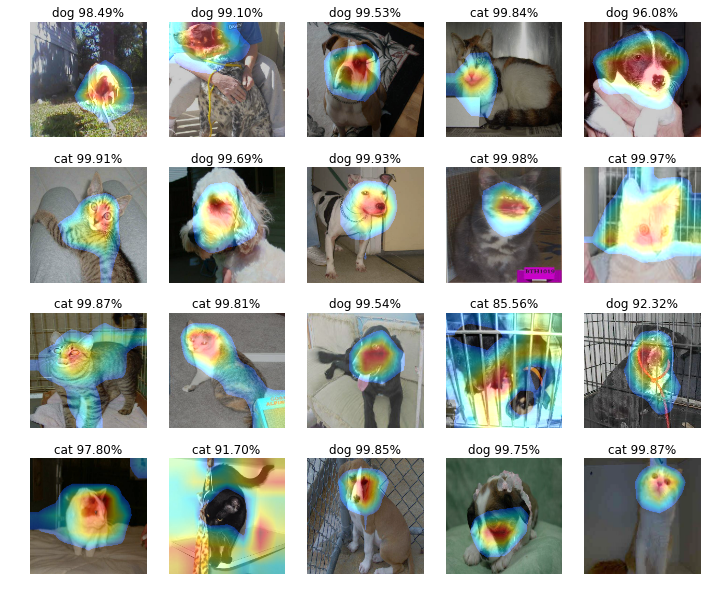

In [21]:
plt.figure(figsize=(12, 10))
for i in range(20):
    img = cv2.imread('test/%d.jpg' % random.randint(1, test_num))
    img = cv2.resize(img, image_size)
    x = img.copy()
    x.astype(np.float32)
    x = x / 255.0
    
    [base_model_outputs, prediction] = model2.predict(np.expand_dims(x, axis=0))
    prediction = prediction[0]
    base_model_outputs = base_model_outputs[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    cam = (prediction - 0.5) * np.matmul(base_model_outputs, weights)

    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8
    
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0
    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
    
    plt.axis('off')
    plt.imshow(out[:,:,::-1])